<a href="https://colab.research.google.com/github/Kunaltembhare003/NYC-taxi-trip-time-Prediction/blob/main/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

#Data preprocessing

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
pip install geopandas

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn import preprocessing

In [75]:
#load NYC Taxi trip time dataset
data = pd.read_csv('/content/drive/MyDrive/alma_better/capstone_project/NYC_Taxi_trip_project/NYC_Taxi_Data.csv',sep=',')
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


no null value in dataset

In [77]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

In [78]:
data.describe().apply(lambda s: s.apply(lambda x: format(x, 'g'))) # to change scientific value to count value

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06
mean,1.53495,1.66453,-73.9735,40.7509,-73.9734,40.7518,959.492
std,0.498777,1.31424,0.0709019,0.0328812,0.0706433,0.0358906,5237.43
min,1,0,-121.933,34.3597,-121.933,32.1811,1
25%,1,1,-73.9919,40.7373,-73.9913,40.7359,397
50%,2,1,-73.9817,40.7541,-73.9798,40.7545,662
75%,2,2,-73.9673,40.7684,-73.963,40.7698,1075
max,2,9,-61.3355,51.8811,-61.3355,43.921,3.52628e+06


Finding Distance by using pickup_lat,pickup_long,dropoff_lat,dropoff_long values

In [79]:
from geopy.distance import great_circle

In [80]:
def find_distance(pickup_lat,pickup_long,dropoff_lat,dropoff_long):
 
 start=(pickup_lat,pickup_long)
 end=(dropoff_lat,dropoff_long)
 
 return great_circle(start,end).km

In [81]:
#finding distance travel in each trip
data['distance'] = data.apply(lambda x: find_distance(x['pickup_latitude'],
                                                      x['pickup_longitude'],
                                                      x['dropoff_latitude'],
                                                      x['dropoff_longitude'] ), axis=1)

#feature creation

AVG SPEED OF VEHICLE

In [82]:
data['avg_speed'] = (data.distance/(data.trip_duration/3600))

In [83]:
data['pickup_weekday']=data['pickup_datetime'].dt.day_name()
data['dropoff_weekday']=data['dropoff_datetime'].dt.day_name()
data['pickup_weekday_num']=data['pickup_datetime'].dt.weekday
data['pickup_hour']=data['pickup_datetime'].dt.hour
data['month']=data['pickup_datetime'].dt.month

In [84]:
# at which time customer board taxi 
def time_of_day(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,16):
        return 'Afternoon'
    elif x in range(16,22):
        return 'Evening'
    else:
        return 'Late night'

In [85]:
data['pickup_timeofday']=data['pickup_hour'].apply(time_of_day)

In [86]:
data.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance,avg_speed,pickup_weekday_num,pickup_hour,month
count,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06
mean,1.53495,1.66453,-73.9735,40.7509,-73.9734,40.7518,959.492,3.44087,14.4232,3.05037,13.6065,3.51682
std,0.498777,1.31424,0.0709019,0.0328812,0.0706433,0.0358906,5237.43,4.29654,14.9775,1.95404,6.39969,1.68104
min,1,0,-121.933,34.3597,-121.933,32.1811,1,0,0,0,0,1
25%,1,1,-73.9919,40.7373,-73.9913,40.7359,397,1.23184,9.12129,1,9,2
50%,2,1,-73.9817,40.7541,-73.9798,40.7545,662,2.09372,12.792,3,14,4
75%,2,2,-73.9673,40.7684,-73.963,40.7698,1075,3.87534,17.8449,5,19,5
max,2,9,-61.3355,51.8811,-61.3355,43.921,3.52628e+06,1240.91,9274.85,6,23,6


In [87]:
data.shape

(1458644, 19)

In [88]:
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance', 'avg_speed', 'pickup_weekday',
       'dropoff_weekday', 'pickup_weekday_num', 'pickup_hour', 'month',
       'pickup_timeofday'],
      dtype='object')

# Univariate Analysis

In [89]:
plt.rcParams["figure.figsize"] = [10,6]

In [90]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,avg_speed,pickup_weekday,dropoff_weekday,pickup_weekday_num,pickup_hour,month,pickup_timeofday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498523,11.856445,Monday,Monday,0,17,3,Evening
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.805510,9.803673,Sunday,Sunday,6,0,6,Late night
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385108,10.822216,Tuesday,Tuesday,1,11,1,Morning
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485501,12.465739,Wednesday,Wednesday,2,19,4,Evening
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.188590,9.836608,Saturday,Saturday,5,13,3,Afternoon


##Column 1 and 2: column 'id' and 'vendor_id' is not relevent to predict trip time

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


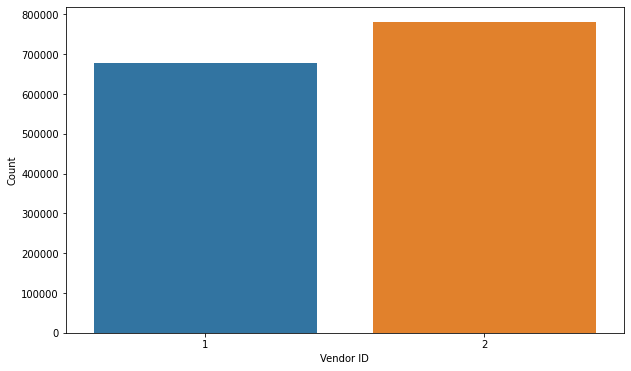

In [91]:
sns.countplot(data.vendor_id)
plt.xlabel('Vendor ID')
plt.ylabel('Count')
plt.show()

## **column 3 and column 4**: from'pickup_datetime' and 'dropoff_datetime' column we created new feature column like '**pickup_weekday**', '**dropoff_weekday**' '**pickup_weekday_num**', '**pickup_hour 	month**', and '**pickup_timeofday**'.

##**column 5: Passenger_count** <br>
from the graph, we can reomve entries with 0, 7, 8, 9 passenger per trip.


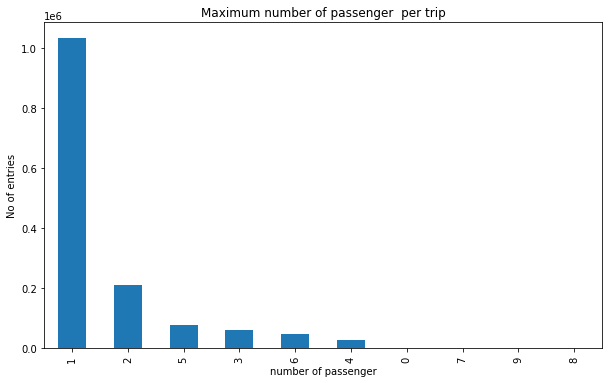

In [92]:
data.passenger_count.value_counts().plot(kind="bar")
plt.xlabel("number of passenger")
plt.ylabel("No of entries")
plt.title("Maximum number of passenger  per trip")
plt.show()



## column 6: pickup_latitude 	pickup_longitude <br>


In [93]:
import folium
from folium.plugins import HeatMap
from folium import plugins


In [94]:
map_NYC = folium.Map([60,-120],zoom_start=7)

In [95]:
'''station = data[['pickup_longitude','pickup_latitude']]
# convert to (n, 2) nd-array format for heatmap
stationArr = station.values

# plot heatmap
map_NYC.add_child(plugins.HeatMap(stationArr, radius=15))
map_NYC'''

"station = data[['pickup_longitude','pickup_latitude']]\n# convert to (n, 2) nd-array format for heatmap\nstationArr = station.values\n\n# plot heatmap\nmap_NYC.add_child(plugins.HeatMap(stationArr, radius=15))\nmap_NYC"

## column 8 & 9: dropoff_latitude 	dropoff_longitude <br>

In [96]:
map_NYC = folium.Map([40.80902,-73.94190],zoom_start=7)

In [97]:
'''station_drop = data[['dropoff_latitude', 'dropoff_longitude']]
# convert to (n, 2) nd-array format for heatmap
stationArr_drop = station_drop.values

# plot heatmap
map_NYC.add_child(plugins.HeatMap(stationArr_drop, radius=15))
map_NYC'''

"station_drop = data[['dropoff_latitude', 'dropoff_longitude']]\n# convert to (n, 2) nd-array format for heatmap\nstationArr_drop = station_drop.values\n\n# plot heatmap\nmap_NYC.add_child(plugins.HeatMap(stationArr_drop, radius=15))\nmap_NYC"

## column 10: Store and forward flag

In [98]:
data['store_and_fwd_flag'].value_counts()

data['store_and_fwd_flag'].value_counts(normalize=True)


N    0.994485
Y    0.005515
Name: store_and_fwd_flag, dtype: float64

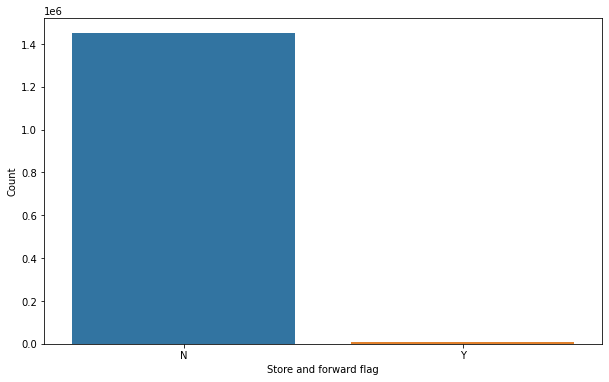

In [99]:
sns.countplot(x='store_and_fwd_flag',data=data)
plt.ylabel('Count')
plt.xlabel('Store and forward flag')
plt.show()

 We can see that only about 0.5% of the trip details were stored in the vehicle memory first

##column 11: trip duration <br>


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


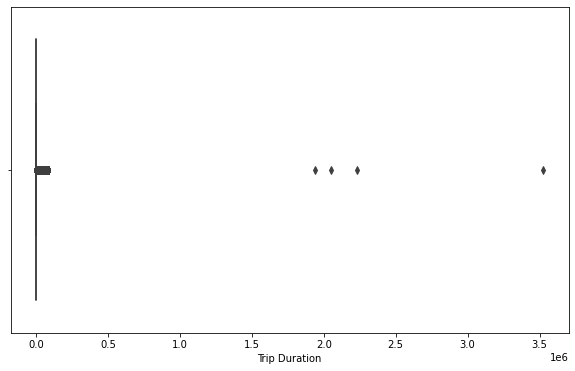

In [100]:
#create boxplot to check probable outliers
sns.boxplot(data.trip_duration)
plt.xlabel('Trip Duration')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


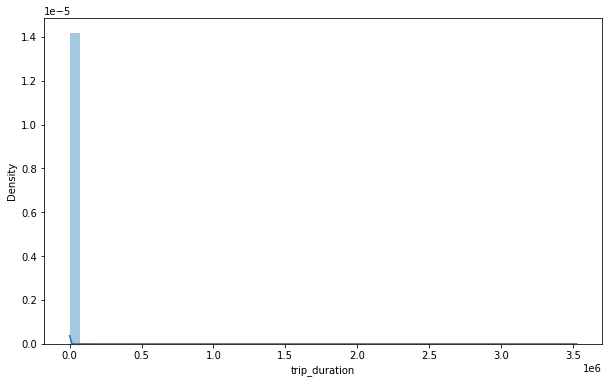

In [101]:
#to check skewness of data 
sns.distplot(data['trip_duration'],norm_hist=True)
plt.show()

In [102]:
print(f" skew coefficient is {data['trip_duration'].skew()}")

 skew coefficient is 343.1639435917362


data is right skewed. using log transformation we can remove skewness.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


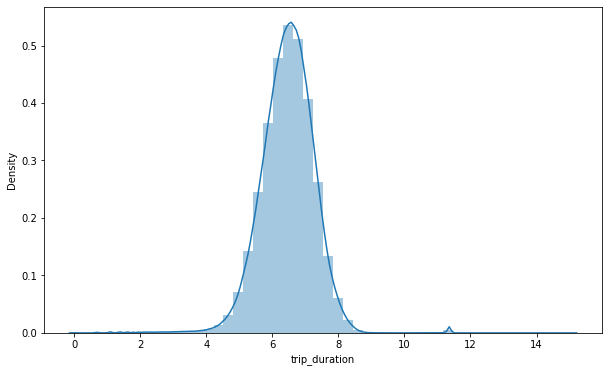

In [103]:
sns.distplot(np.log(data['trip_duration']))
plt.show()

In [104]:
np.log(data['trip_duration'])
data_trip_duration = np.log(data['trip_duration'])
print(f" skew coefficient went from {data['trip_duration'].skew()} to {data_trip_duration.skew()}")

 skew coefficient went from 343.1639435917362 to -0.34070423044801745


## column 12: distance <br>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


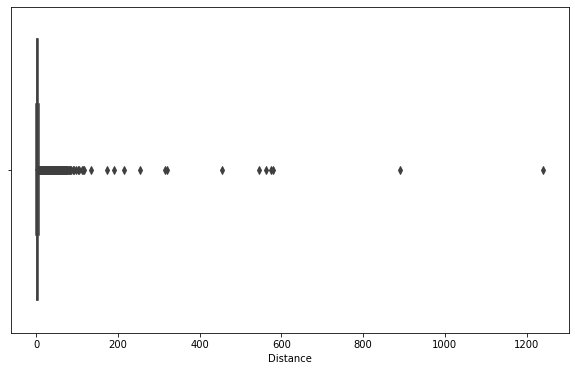

In [105]:
sns.boxplot(data.distance)
plt.xlabel('Distance')
plt.show()

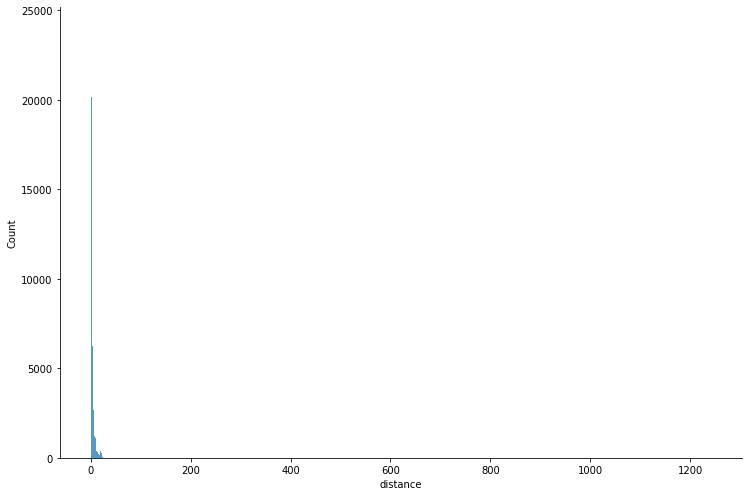

In [106]:

sns.displot(data=data, x='distance', height=7,aspect=1.5)
plt.show()

In [107]:
print(f"Skew coefficient is {data['distance'].skew()}")

Skew coefficient is 32.63098100465965


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


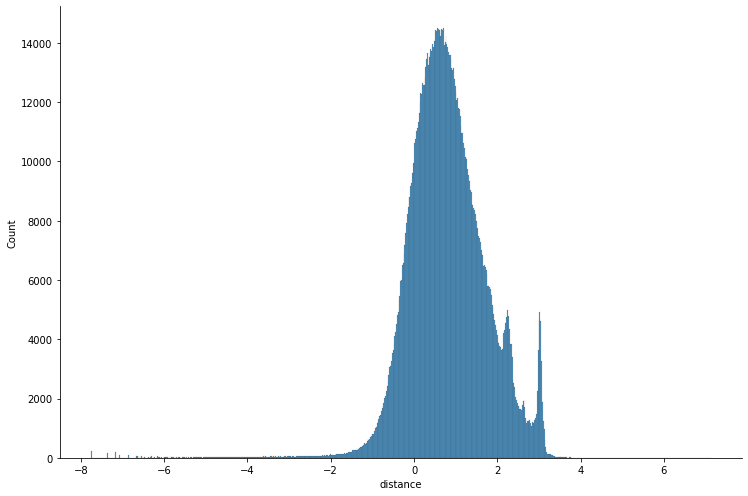

In [108]:
sns.displot(np.log(data["distance"]), height=7,aspect=1.5)
plt.show()

In [109]:
distance_log_skew = np.log(data["distance"]).skew()
print(f" Skew coefficient went from {data['distance'].skew()} to {distance_log_skew}")

 Skew coefficient went from 32.63098100465965 to nan


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


it's 

## column 13: Average speed

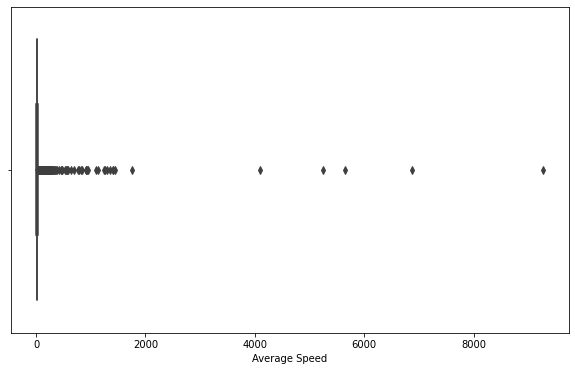

In [110]:
sns.boxplot(x="avg_speed", data=data)
plt.xlabel('Average Speed')
plt.show()

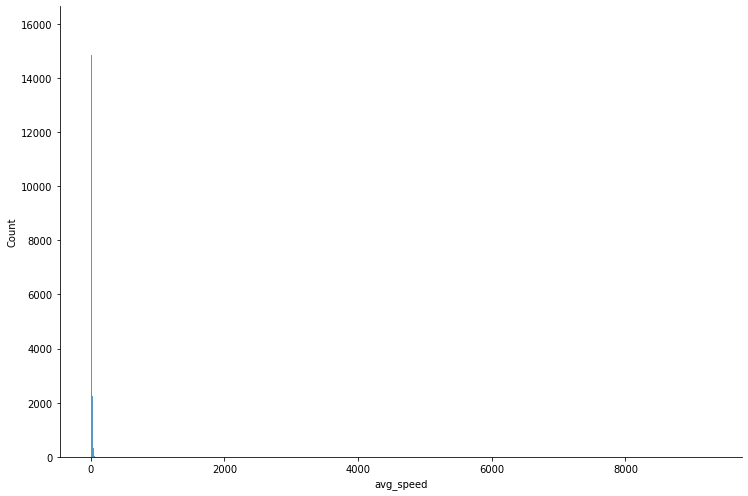

In [111]:

sns.displot(data=data, x='avg_speed', height=7,aspect=1.5)
plt.show()

In [112]:
print(f"Skew coefficient is {data['avg_speed'].skew()}")

Skew coefficient is 314.1581085599962


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


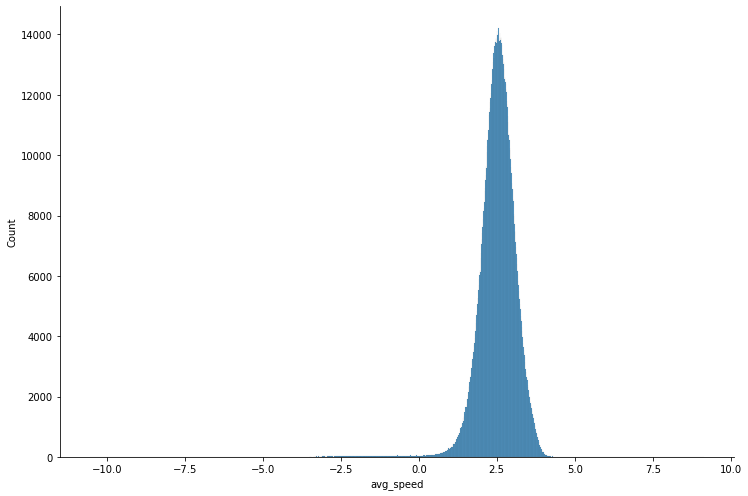

In [113]:
sns.displot(np.log(data["avg_speed"]), height=7,aspect=1.5)
plt.show()

In [114]:
speed_log_skew = np.log(data["avg_speed"]).skew()
print(f" Skew coefficient went from {data['avg_speed'].skew()} to {speed_log_skew}")

 Skew coefficient went from 314.1581085599962 to nan


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


it's 

## column 14 and 15: pickup_weekday and drop off weekday


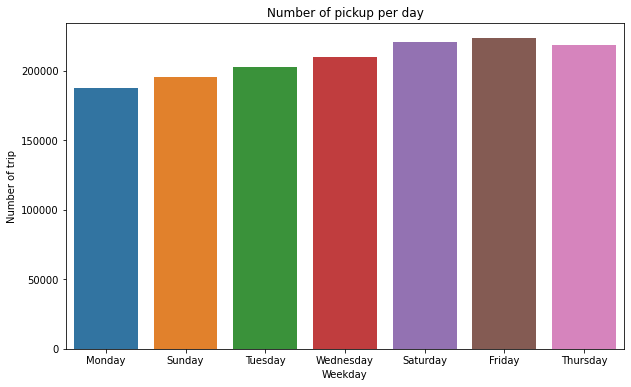

In [115]:
sns.countplot(data=data, x='pickup_weekday')
plt.ylabel('Number of trip')
plt.xlabel('Weekday')
plt.title('Number of pickup per day')
plt.show()

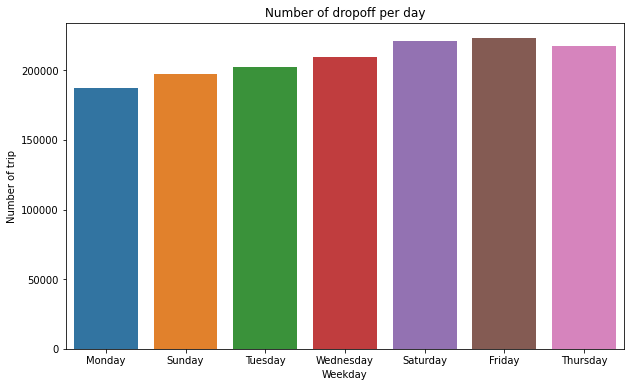

In [116]:
sns.countplot(data=data, x='dropoff_weekday')
plt.ylabel('Number of trip')
plt.xlabel('Weekday')
plt.title('Number of dropoff per day')
plt.show()

## column 16: pick up hour

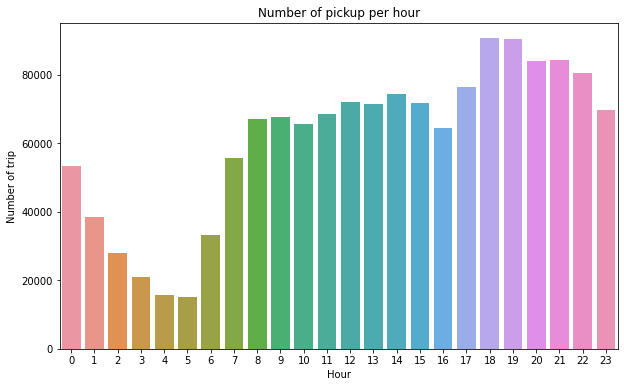

In [117]:
sns.countplot(data=data, x='pickup_hour')
plt.ylabel('Number of trip')
plt.xlabel('Hour')
plt.title('Number of pickup per hour')
plt.show()

## column 17: month

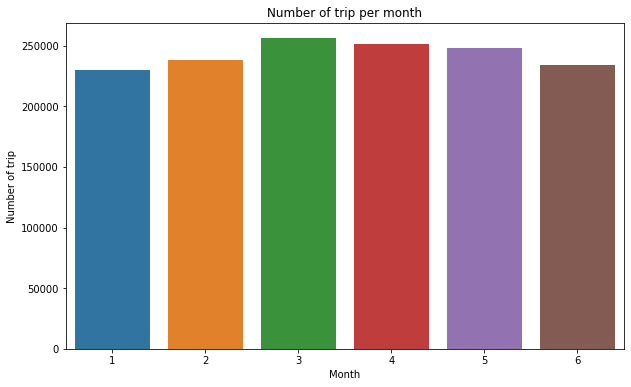

In [118]:
sns.countplot(data=data, x='month')
plt.ylabel('Number of trip')
plt.xlabel('Month')
plt.title('Number of trip per month')
plt.show()

In [119]:
data.month.value_counts()

3    256189
4    251645
5    248487
2    238300
6    234316
1    229707
Name: month, dtype: int64

##column 18: pick up time of day

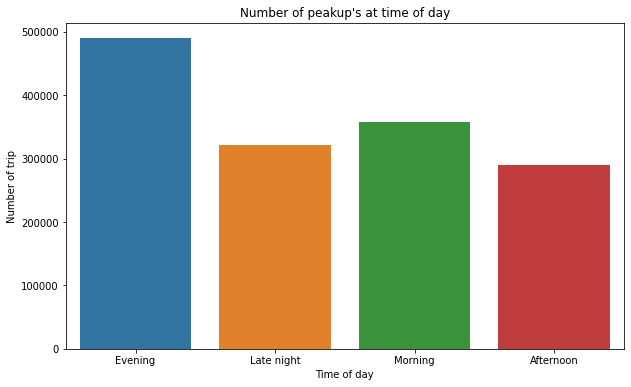

In [120]:
# bar plot for pickup time of a day
sns.countplot(data=data, x="pickup_timeofday")
plt.xlabel("Time of day")
plt.ylabel("Number of trip")
plt.title("Number of peakup's at time of day")
plt.show()


# **feature Enginerring** <br>

## **Data cleaing and wrangling**

In [121]:
# remove column  "id" and "vendor_id"
data.drop(["id","vendor_id","pickup_weekday",'pickup_datetime',"dropoff_datetime"],axis=1,inplace= True)

In [122]:
data.shape

(1458644, 14)

In [123]:
#remove rows with passenger count value =0,7,8,9
df = data.loc[~(data['passenger_count']==0)]
df = df.loc[~(df['passenger_count'] >= 7)]

In [124]:
df.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
Name: passenger_count, dtype: int64

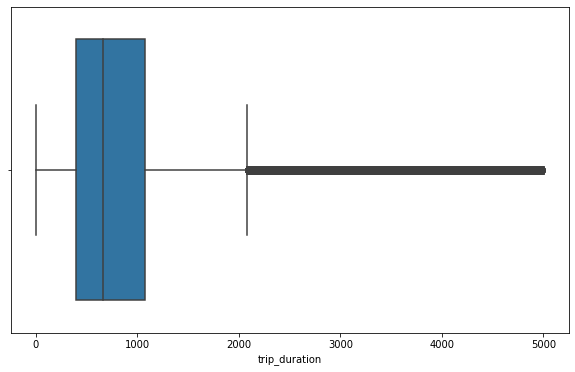

In [125]:
#remove trip duration greater than 5000 second
df = df.loc[~(df['trip_duration'] >= 5000)]
#plot boxplot for filtered data
sns.boxplot(data=df,x='trip_duration')
plt.show()

In [126]:
df.shape

(1454806, 14)

In [127]:
#remove distance above 200 and avg_speed above 50 km/hr (As 2015, maximum speed limit was 48.28 kmph)
df = df.loc[~((df['distance']>=200) | (df["avg_speed"]>=50))]

In [128]:
df.shape

(1451851, 14)

In [131]:
# remove rows if distance travel is zero
df = df[df.distance != 0]

In [132]:
df.shape

(1445968, 14)

##log Transfrom <br>
Logarithm transformation (or log transform) is one of the most commonly used mathematical transformations in feature engineering. What are the benefits of log transform:


*   It helps to handle skewed data and after transformation, the distribution becomes more approximate to normal.
*   In most of the cases the magnitude order of the data changes within the range of the data.
*   It also decreases the effect of the outliers, due to the normalization of magnitude differences and the model become more robust.

 


In [133]:
df['avg_speed'] = (df['avg_speed']).transform(np.log)
df['distance'] = (df['distance']).transform(np.log)
df['trip_duration'] = (df['trip_duration']).transform(np.log)

In [134]:
df.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,avg_speed,dropoff_weekday,pickup_weekday_num,pickup_hour,month,pickup_timeofday
0,1,-73.982155,40.767937,-73.964630,40.765602,N,6.120297,0.404480,2.472872,Monday,0,17,3,Evening
1,1,-73.980415,40.738564,-73.999481,40.731152,N,6.496775,0.590843,2.282757,Sunday,6,0,6,Late night
2,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661056,1.853968,2.381601,Tuesday,1,11,1,Morning
3,1,-74.010040,40.719971,-74.012268,40.706718,N,6.061457,0.395752,2.522984,Wednesday,2,19,4,Evening
4,1,-73.973053,40.793209,-73.972923,40.782520,N,6.075346,0.172768,2.286111,Saturday,5,13,3,Afternoon


#corelation 

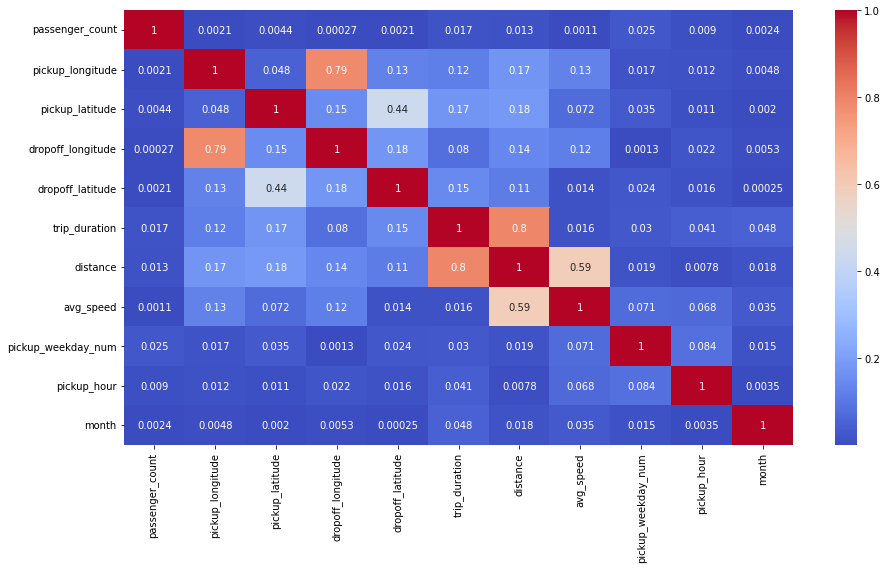

In [135]:
 ## Correlation
plt.figure(figsize=(15,8))
correlation = df.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')
plt.show()

As we can see that,  <br>
"dropoff_longitude" is 79% corelated with "pickup_longitude".  <br>
"Avg_speed" is 40% corealted with distance. <br>
"trip_duration" is 67% corealted with distance.

In [153]:
df.drop(['pickup_weekday_num'],axis=1,inplace=True)

##check multi collinearity

In [136]:
#Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
#define function to call multicollinearity
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [68]:
df.columns

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance', 'avg_speed', 'dropoff_weekday',
       'pickup_weekday_num', 'pickup_hour', 'month', 'pickup_timeofday'],
      dtype='object')

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451851 entries, 0 to 1458643
Data columns (total 14 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   passenger_count     1451851 non-null  int64  
 1   pickup_longitude    1451851 non-null  float64
 2   pickup_latitude     1451851 non-null  float64
 3   dropoff_longitude   1451851 non-null  float64
 4   dropoff_latitude    1451851 non-null  float64
 5   store_and_fwd_flag  1451851 non-null  object 
 6   trip_duration       1451851 non-null  float64
 7   distance            1451851 non-null  float64
 8   avg_speed           1451851 non-null  float64
 9   dropoff_weekday     1451851 non-null  object 
 10  pickup_weekday_num  1451851 non-null  int64  
 11  pickup_hour         1451851 non-null  int64  
 12  month               1451851 non-null  int64  
 13  pickup_timeofday    1451851 non-null  object 
dtypes: float64(7), int64(4), object(3)
memory usage: 166.2+ MB


In [144]:
calc_vif(df[[i for i in df.describe().columns if i not in ['passenger_count','store_and_fwd_flag', 'dropoff_weekday', 'pickup_weekday_num','pickup_hour','month','pickup_timeofday','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']]])

,variables,VIF
0,trip_duration,15.988290
1,distance,2.141564
2,avg_speed,16.856697


we have also remove the Avg_speed feature from the predictor columns as it highhly  corelated with distance.

In [145]:
calc_vif(df[[i for i in df.describe().columns if i not in ['passenger_count','store_and_fwd_flag', 'dropoff_weekday', 'pickup_weekday_num','pickup_hour','month','pickup_timeofday','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','avg_speed']]])

,variables,VIF
0,trip_duration,2.029055
1,distance,2.029055


##hot encoding

In [146]:
df.columns

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance', 'avg_speed', 'dropoff_weekday',
       'pickup_weekday_num', 'pickup_hour', 'month', 'pickup_timeofday'],
      dtype='object')

In [154]:
# One hot encoding
final_data = pd.get_dummies(df, columns=["store_and_fwd_flag",
                                         "dropoff_weekday",
                                         "pickup_hour",
                                         "month",
                                         "pickup_timeofday"])

In [155]:
final_data.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance,avg_speed,store_and_fwd_flag_N,store_and_fwd_flag_Y,dropoff_weekday_Friday,dropoff_weekday_Monday,dropoff_weekday_Saturday,dropoff_weekday_Sunday,dropoff_weekday_Thursday,dropoff_weekday_Tuesday,dropoff_weekday_Wednesday,pickup_hour_0,pickup_hour_1,pickup_hour_2,pickup_hour_3,pickup_hour_4,pickup_hour_5,pickup_hour_6,pickup_hour_7,pickup_hour_8,pickup_hour_9,pickup_hour_10,pickup_hour_11,pickup_hour_12,pickup_hour_13,pickup_hour_14,pickup_hour_15,pickup_hour_16,pickup_hour_17,pickup_hour_18,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23,month_1,month_2,month_3,month_4,month_5,month_6,pickup_timeofday_Afternoon,pickup_timeofday_Evening,pickup_timeofday_Late night,pickup_timeofday_Morning
0,1,-73.982155,40.767937,-73.964630,40.765602,6.120297,0.404480,2.472872,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,1,-73.980415,40.738564,-73.999481,40.731152,6.496775,0.590843,2.282757,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,1,-73.979027,40.763939,-74.005333,40.710087,7.661056,1.853968,2.381601,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,1,-74.010040,40.719971,-74.012268,40.706718,6.061457,0.395752,2.522984,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,1,-73.973053,40.793209,-73.972923,40.782520,6.075346,0.172768,2.286111,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


Now we see corelation heatmap between each feature to choose best feature.

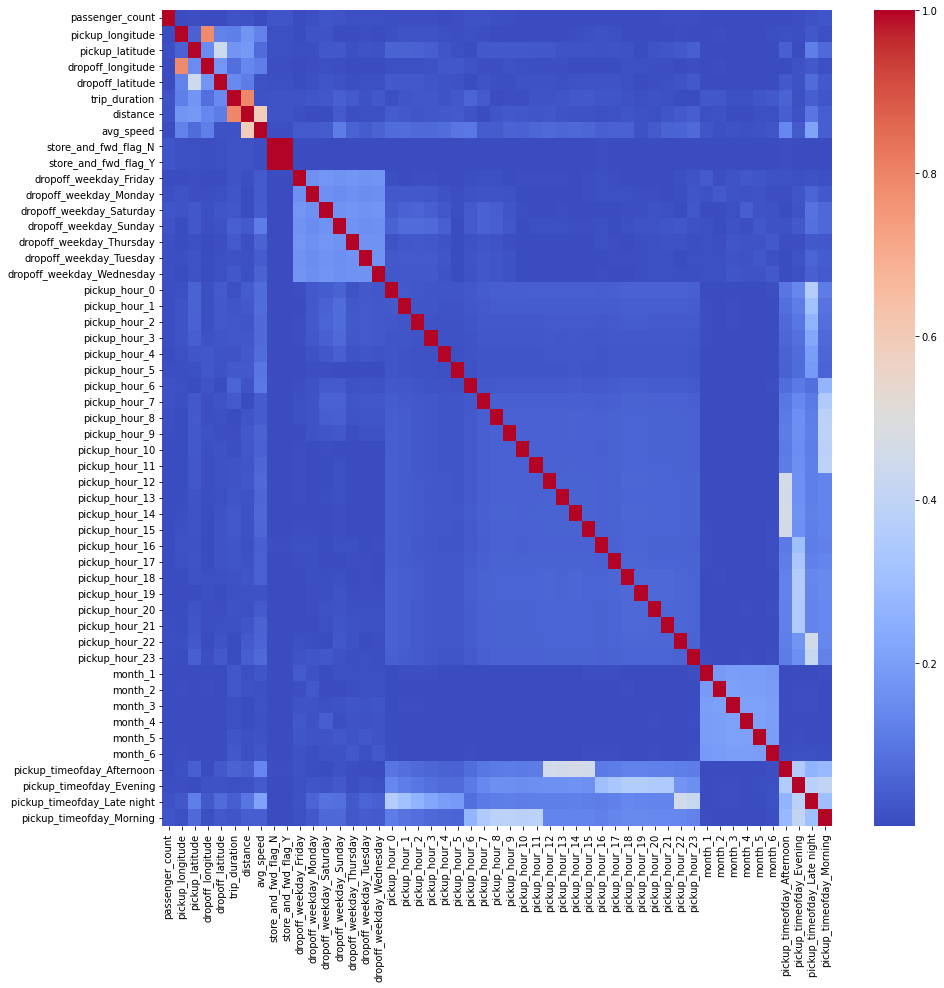

In [156]:
 ## Correlation
plt.figure(figsize=(15,15))
correlation_1 = final_data.corr()
sns.heatmap(abs(correlation_1), annot=False, cmap='coolwarm')
plt.show()